In [14]:
import sys
sys.path.append("../")

In [15]:
from libs.Lsh import LSH 

In [16]:
import numpy
from matplotlib import pyplot, mlab
import scipy.io.wavfile
from collections import defaultdict
import librosa

SAMPLE_RATE = 8000 # Hz
WINDOW_SIZE = 2048 # размер окна, в котором делается fft
WINDOW_STEP = 512 # шаг окна

def get_wave_data(wave_filename):
    sample_rate, wave_data = scipy.io.wavfile.read(wave_filename)

    wave_data, sample_rate = librosa.load(wave_filename, mono=True, sr=8000)

    # less_rate = librosa.resample(wave_data[0], orig_sr=sample_rate, target_sr=8000)
    # assert less_rate == SAMPLE_RATE, sample_rate
    if isinstance(wave_data[0], numpy.ndarray): # стерео
        wave_data = wave_data.mean(1)
    return wave_data

def show_specgram(wave_data):
    fig = pyplot.figure()
    ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
    ax.specgram(wave_data,
        NFFT=WINDOW_SIZE, noverlap=WINDOW_SIZE - WINDOW_STEP, Fs=SAMPLE_RATE)
    pyplot.show()

wave_data1 = get_wave_data('test_1.wav')
wave_data2 = get_wave_data('test_2.wav')

In [19]:

import sys

import numpy
from scipy.io import wavfile
from scipy.signal import fftconvolve


needle, needle_rate = librosa.load("val.wav",mono=True,sr = 11025)
haystack, haystack_rate = librosa.load("lic.wav",mono=True,sr = 11025)

print(needle.shape)

if needle_rate != haystack_rate:
    print >> sys.stderr, "Sample rates are not the same"
    sys.exit(2)

if len(needle.shape) != 1:
    print >> sys.stderr, "Needle file is not mono"
    sys.exit(2)

if len(haystack.shape) != 1:
    print >> sys.stderr, "Haystack file is not mono"
    sys.exit(2)

if len(needle) == 0:
    print >> sys.stderr, "Needle is empty"
    sys.exit(2)

if len(needle) > len(haystack):
    print >> sys.stderr, "Needle is longer than haystack"
    sys.exit(2)

needle = numpy.array(needle, dtype=numpy.float64)
needle_len = len(needle)
haystack = numpy.array(haystack, dtype=numpy.float64)
haystack_len = len(haystack)

needle_norm = needle.dot(needle)

if needle_norm < 1000.0:
    print >> sys.stderr, "The needle is almost silent"
    sys.exit(2)

haystack_squared = numpy.hstack(([0.0], haystack * haystack))
haystack_cum_norm = numpy.cumsum(haystack_squared)
haystack_norm_at = haystack_cum_norm[needle_len:haystack_len + 1] - haystack_cum_norm[0:haystack_len + 1 - needle_len]

correlation_at = fftconvolve(haystack, needle[::-1], mode='valid')

difference_norm_at = haystack_norm_at + needle_norm - 2 * correlation_at

cos2phi_at = correlation_at * correlation_at / (haystack_norm_at + 0.000001) / needle_norm

gain_at = correlation_at / needle_norm
descaled_difference_norm_at = haystack_norm_at + needle_norm * gain_at * gain_at - 2 * gain_at * correlation_at

at = 0

mode = "this"

if mode == 'like':
    at = numpy.argmax(correlation_at)
if mode == 'similar':
    at = numpy.argmax(cos2phi_at)
if mode == 'this':
    at = numpy.argmin(difference_norm_at)


print ("The needle starts at sample: %d" % ((at/11025)/60,))
print ("Gain (dB): %3.2f" % (20.0 * numpy.log10(numpy.abs(gain_at[at]) + 0.000001),))
print ("SNR (dB), treating gain change as noise: %3.2f" % (
    10.0 * numpy.log10(gain_at[at] * gain_at[at] * needle_norm / (difference_norm_at[at] + 0.000001)),))
print ("SNR (dB), treating gain change as signal: %3.2f" % (
    10.0 * numpy.log10(gain_at[at] * gain_at[at] * needle_norm / (descaled_difference_norm_at[at] + 0.000001)),))

(8758528,)
The needle starts at sample: 16
Gain (dB): -50.42
SNR (dB), treating gain change as noise: -53.89
SNR (dB), treating gain change as signal: -51.31


In [ ]:
import hashlib

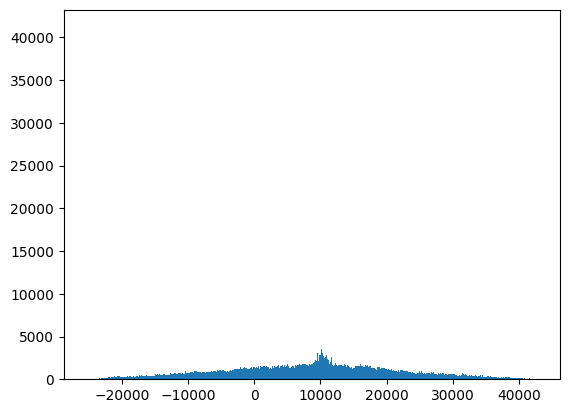

336.256
Наибольший пик в гистограмме: 5254
Временной отрезок с максимальным совпадением: 336.256 секунд


In [ ]:
def get_fingerprint(wave_data):
    # pxx[freq_idx][t] - мощность сигнала
    S_db = librosa.stft(wave_data,n_fft=WINDOW_SIZE,hop_length=WINDOW_STEP)
    S_db = numpy.abs(S_db)**2
    # pxx, _, _ = mlab.specgram(wave_data,
    #     NFFT=WINDOW_SIZE, noverlap=WINDOW_SIZE-WINDOW_STEP, Fs=SAMPLE_RATE)
    band = S_db[15:250]  # наиболее интересные частоты от 60 до 1000 Hz
    return numpy.argmax(band.transpose(), 1)  # max в каждый момент времени

fp1 = get_fingerprint(wave_data2)
fp2 = get_fingerprint(wave_data1)

def compare_fingerprints(base_fp, fp):
    base_fp_hash = defaultdict(list)
    for time_index, freq_index in enumerate(base_fp):
        base_fp_hash[freq_index].append(time_index)
    matches = [t - time_index  # разницы времен совпавших частот
        for time_index, freq_index in enumerate(fp)
        for t in base_fp_hash[freq_index]]
    pyplot.clf()
    pyplot.hist(matches, 10048)
    pyplot.show()

    return matches

res = compare_fingerprints(fp1, fp2)

max_match_index = numpy.argmax(numpy.histogram(res, bins=10048)[0])
time_offset = max_match_index * WINDOW_STEP / SAMPLE_RATE
print(time_offset)
print(f"Наибольший пик в гистограмме: {max_match_index}")
print(f"Временной отрезок с максимальным совпадением: {time_offset} секунд")